In [1]:
import random
import numpy as np
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib.pyplot as plt
import pandas as pd 
import hts
from hts.hierarchy import HierarchyTree

from  forecasting_functions import probabilistic_forecasting
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import TCNModel,StatsForecastAutoARIMA,NHiTSModel
import scipy.stats as ss
from darts.utils.likelihood_models import GaussianLikelihood

import properscoring as ps

# Fitting ARIMA model manually 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from sklearn.metrics import mean_squared_error
import itertools 



In [ ]:
''' pl follow steps from: https://github.com/time-series-foundation-models/lag-llama/blob/main/README.md 
to set the working directory '''

In [88]:
cd /lag-llama/


/home/santoshpalaskar77/hbpf/Time series models/ECAI/lag-llama


In [89]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir  lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
ECAI/lag-llama/ecai_final_codes/lag-llama.ckpt


In [10]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

ModuleNotFoundError: No module named 'lag_llama'

In [3]:
df = pd.read_csv("Labour.csv")

try:
    test_len = int(input("Please enter the test length as an integer: "))
    print(f"Test length is set to: {test_len}")
except ValueError:
    print("Invalid input. Please enter a valid integer.")


Test length is set to: 8


In [91]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

In [4]:
df.rename(columns = {'Total':'total','Unnamed: 0':'date'}, inplace = True)

columns1 = df.columns.to_list()
columns1 = [element.replace("'", "").strip("[]").replace(',', '').replace(' ', '')  for element in columns1]

columns1
df.columns = columns1
df.rename(columns = {'Total':'total'}, inplace = True)
df =df.set_index('date')

df11 =df
# %%
# Here we set the length of the train, test and validation set 
# We can generate the time series of desired size using following parameters
#there are total 36 data points in each time series 
total_len = len(df)
train_len =  total_len-test_len
split_val = train_len
freq = 'M'

# %%

''' To use the Darts model, we need to transform the data into the form mentoned in their documentation.
 First, we create the levels according to the hierarchical structure and then 
 define the hierarchy.    
 '''
#levels and hierarchy will vary from data to data 

level0 = [0]        # level 0
level1 = np.array(df.columns[1:9])  # level 1
level1_r = list(range(1,9))    
level2 = np.array(df.columns[9:25])  
level2_r = list(range(9,25))
level3 = np.array(df.columns[25:len(df.columns)])
level3_r = list(range(25,len(df.columns)))                     
levels = [level0,level1_r,level2_r,level3_r]
bottom_level = level3_r
levels1 = [level1,level2,level3]

agg_length= 25

# %%
# Defining hierarchy

total = {'total' : list(level1)}
level1_h = {k: [v for v in level2  if v.endswith(k)] for k in level1}
level2_h = {k: [v for v in level3  if v.endswith(k)] for k in level2}


hierarchy = {**total,**level1_h,**level2_h}

aac = list(hierarchy.keys())   # aggregated series 
aab= list(hierarchy.values())  # child nodes of each aggregated series 

# %%
level1

# %%
'''Defining aggregation structure that will be needed while geeting the aggregated
forecast using child node forecasts'''
agg_structure1 = []
for i in range(len(aac)):
    for j in range(len(levels1)):
        if aab[i][0] in levels1[j]:
            abcd = []
            for l in aab[i]:
                abcd.append(list(levels1[j]).index(l))
            agg_structure1.append(abcd)


'''Adding bottom level to the aggregation structure'''
for i in range(len(bottom_level)):
    agg_structure1.append([i])
    

# %%
#defining the tree for hierarchy 
ht = HierarchyTree.from_nodes(nodes=hierarchy, df=df)
sum_mat, sum_mat_labels = hts.functions.to_sum_mat(ht) #sum_mat_lables are the all the nodes in the hierarchy
df2 = pd.DataFrame(columns = sum_mat_labels)

#defining the dataframe according to the hierarchy
for col in sum_mat_labels:
    df2[col] = df[col]
    
df2 = df.iloc[: , :len(agg_structure1)]
df2['date'] =  df2.index
df =df2
df = df.drop(df.columns[-1], axis=1)
df_test = df[train_len: len(df2)] # remaining 10 points as test
columns = df.columns

df_list = []        # origignal data in list format 
for i in columns:
    df_list.append(df2[i].to_list())
# %%

/tmp/ipykernel_3919242/2759662108.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['date'] =  df2.index


In [93]:
from gluonts.dataset.common import ListDataset

In [95]:
metadata = {
    'prediction_length': test_len,
    'freq': '1M'
}


train_data = [{"start": df.index[0], "target": df[i].values[:-metadata['prediction_length']]} for i in df.columns]
test_data = [{"start": df.index[0], "target": df[i].values} for i in df.columns]

train_ds = ListDataset(
    data_iter=train_data,
    freq=metadata['freq']
)

test_ds = ListDataset(
    data_iter=test_data,
    freq=metadata['freq']
)
device = torch.device("cuda:0")

In [96]:
#metadata
prediction_length = test_len
context_length = test_len
num_samples = 48
device = "cuda"

In [97]:
forecasts, tss = get_lag_llama_predictions(
    test_ds,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/57 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/57 [00:00<?, ?it/s]

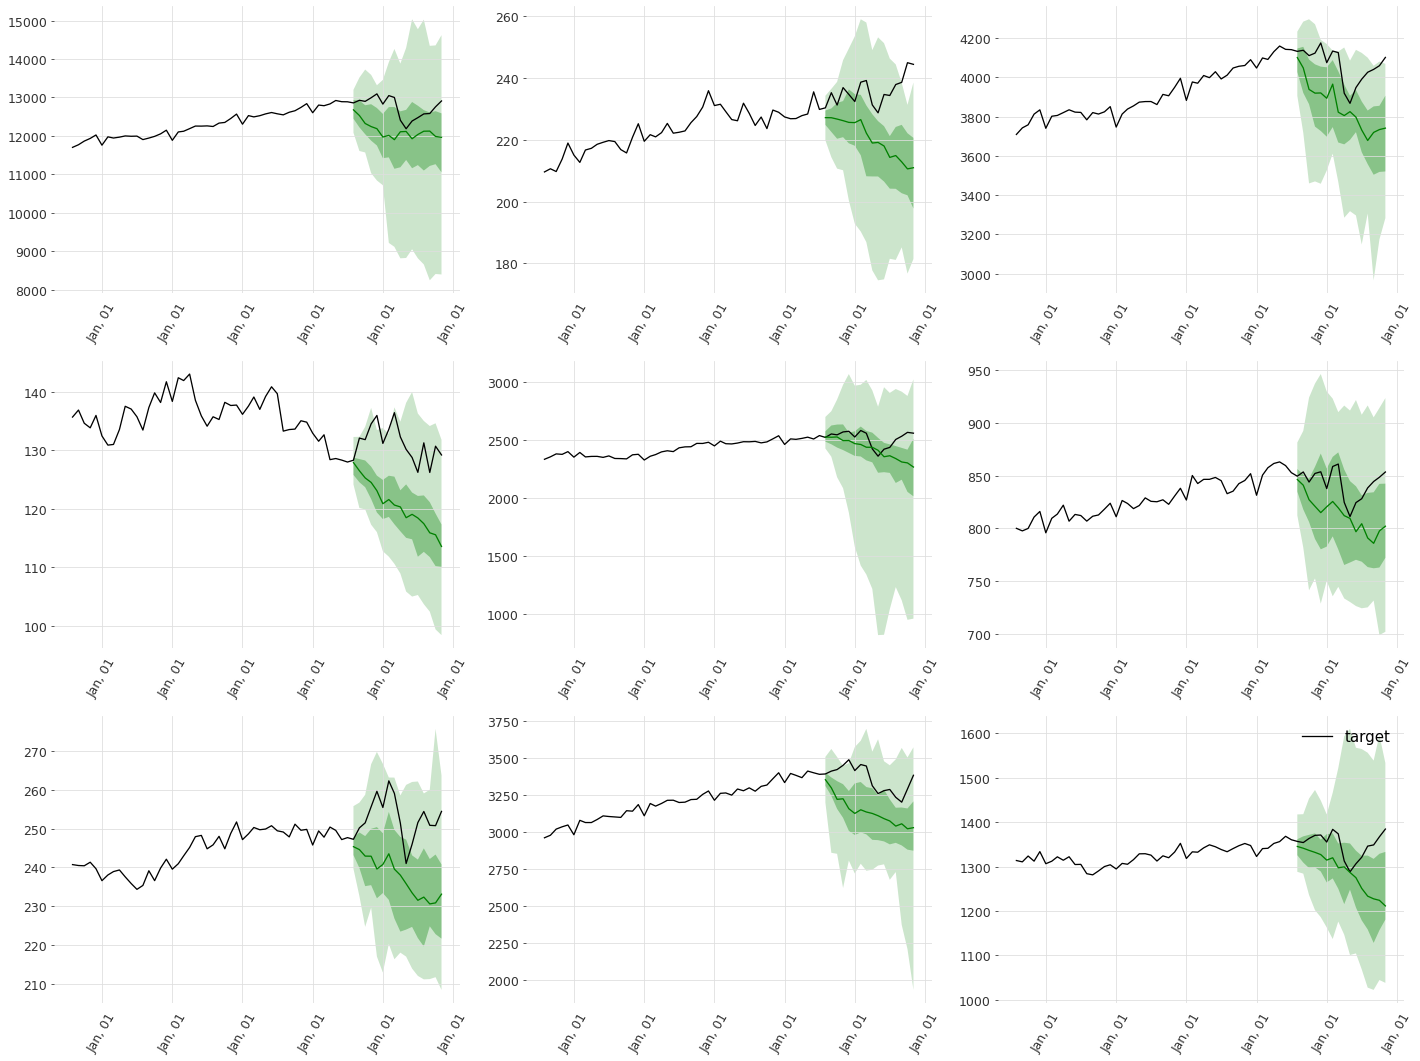

In [98]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [99]:
from gluonts.evaluation import Evaluator
quantile = [0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9]

evaluator = Evaluator(quantiles=quantile)
agg_metrics, item_metrics = evaluator(tss, forecasts)


Running evaluation: 57it [00:01, 49.39it/s]
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


{'MSE': 15091.84517536247,
 'abs_error': 44363.55041503906,
 'abs_target_sum': 815688.370223999,
 'abs_target_mean': 894.3951427894726,
 'seasonal_error': 15.277857404178285,
 'MASE': 2.5943358479095515,
 'MAPE': 0.058283592590637374,
 'sMAPE': 0.06043205243584357,
 'MSIS': 19.9357503431474,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 24879.67133350372,
 'Coverage[0.1]': 0.007675438596491228,
 'QuantileLoss[0.2]': 36751.39769668579,
 'Coverage[0.2]': 0.01644736842105263,
 'QuantileLoss[0.3]': 43105.7735206604,
 'Coverage[0.3]': 0.03837719298245614,
 'QuantileLoss[0.4]': 45530.71506385804,
 'Coverage[0.4]': 0.07346491228070176,
 'QuantileLoss[0.5]': 44363.55035114288,
 'Coverage[0.5]': 0.12938596491228072,
 'QuantileLoss[0.6]': 40076.431414031984,
 'Coverage[0.6]': 0.19956140350877194,
 'QuantileLoss[0.7]': 31876.12029685974,
 'Coverage[0.7]': 0.35526315789473684,
 'QuantileLoss[0.8]': 21563.129481887816,
 'Coverage[0.8]': 0.5635964912280702,
 'QuantileLoss[0.9]': 15193.9140

In [100]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=1e-2,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=32,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 150,}, # <- lightning trainer arguments
    )

In [101]:
from gluonts.evaluation import make_evaluation_predictions

In [102]:
predictor = estimator.train(train_ds, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                                   …

Epoch 0, global step 50: 'train_loss' reached 6.73922 (best 6.73922), saving model to '/home/santoshpalaskar77/hbpf/Time series models/ECAI/lag-llama/lightning_logs/version_209/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.20991 (best 5.20991), saving model to '/home/santoshpalaskar77/hbpf/Time series models/ECAI/lag-llama/lightning_logs/version_209/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' reached 5.11648 (best 5.11648), saving model to '/home/santoshpalaskar77/hbpf/Time series models/ECAI/lag-llama/lightning_logs/version_209/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 4.91243 (best 4.91243), saving model to '/home/santoshpalaskar77/hbpf/Time series models/ECAI/lag-llama/lightning_logs/version_209/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 4.84183 (be

In [103]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,
        predictor=predictor,
        num_samples=num_samples,
    )

In [104]:
forecasts =  list(tqdm(forecast_it, desc="Forecasting batches"))
tss =  list(tqdm(ts_it,desc="Ground truth"))

Forecasting batches: 0it [00:00, ?it/s]

Ground truth: 0it [00:00, ?it/s]

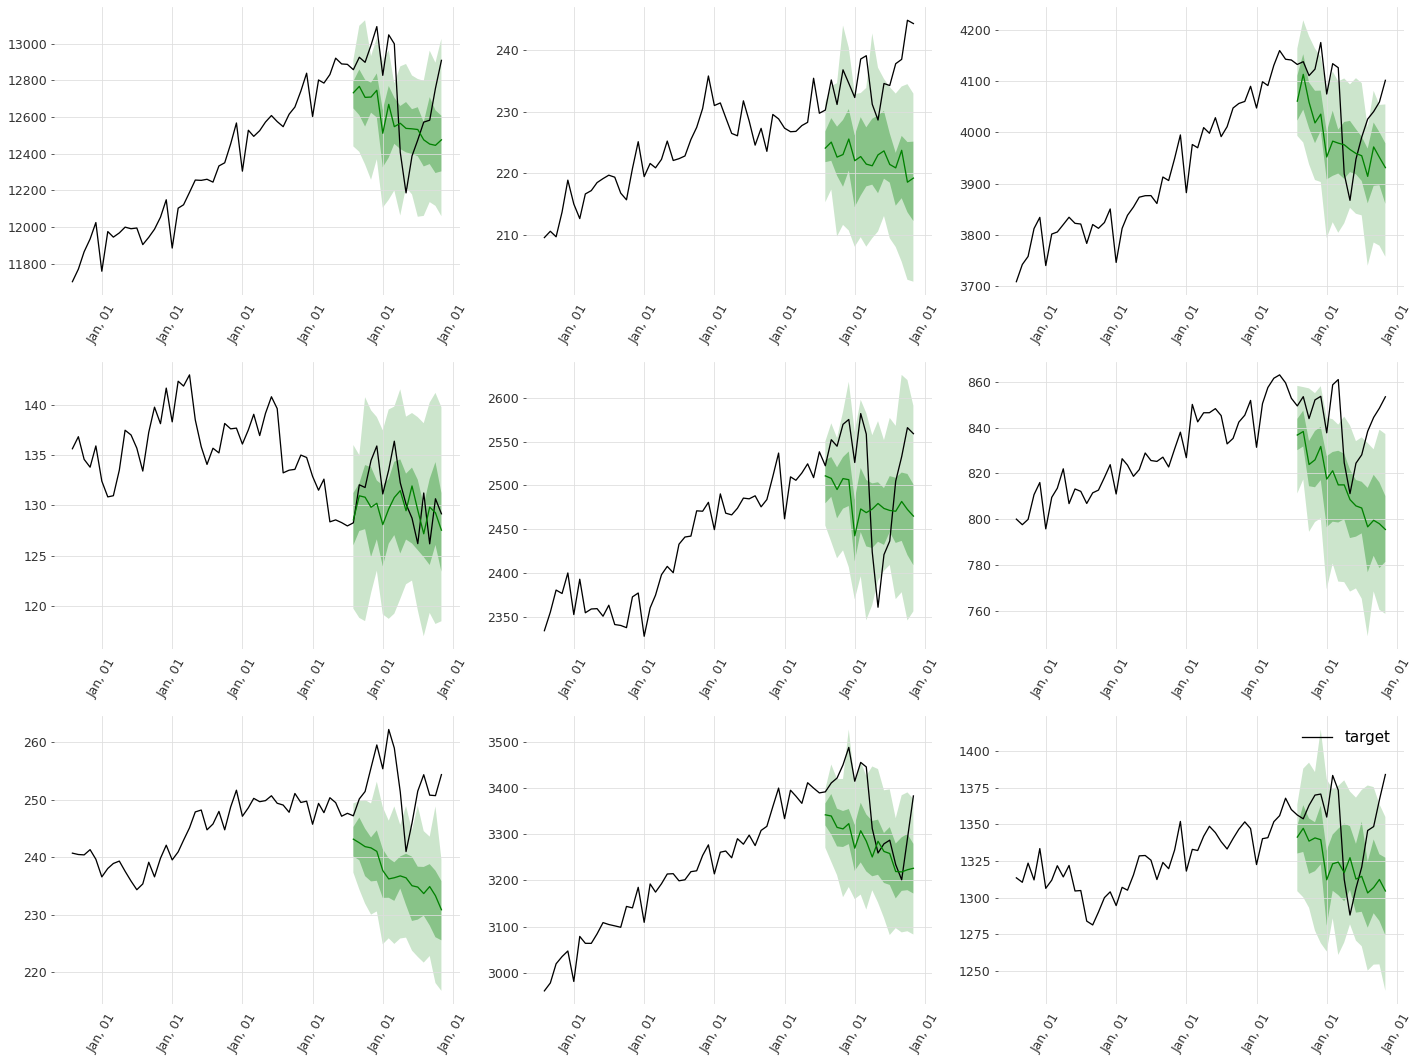

In [105]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [106]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=quantile)
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 57it [00:01, 52.32it/s]
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [108]:

def process_forecasts(forecasts):
    samples1 = [forecast.samples for forecast in forecasts]
    samples = np.transpose(samples1, (0, 2, 1))
    samples = np.array(samples)
    return samples

# Usage example:
samples = process_forecasts(forecasts)


In [109]:
import numpy as np


a = num_samples
hist_i = a // metadata['prediction_length']

past_m = []   
past_std = []

for i in range(hist_i):
    try:
        train_data_h = [{"start": df11.index[0], "target": df11[i1].values[:-a ]} for i1 in df11.columns]
        train_ds_h = ListDataset(data_iter=train_data_h, freq=metadata['freq'])
        forecast_it_h, ts_it_h = make_evaluation_predictions(
            dataset=train_ds_h,
            predictor=predictor,
            num_samples=num_samples)

        forecasts_h = list(tqdm(forecast_it_h, desc="Forecasting batches"))
        tss_h = list(tqdm(ts_it_h, desc="Ground truth"))
    
        samples11 = []
        for n in range(len(forecasts_h)):
            samples11.append(forecasts_h[n].samples)
            
        samples1 = np.transpose(samples11, (0, 2, 1))
        samples1 = samples1.tolist()
        samples1 = np.array(samples1)

        for k in range(len(samples1)):
            aa = np.mean(samples1[k], axis=1)
            ab = np.std(samples1[k], axis=1)
            
            if i <= 0:
                past_m.append(aa)
                past_std.append(ab)
            else:
                past_m[k] = np.hstack((past_m[k], aa))
                past_std[k] = np.hstack((past_std[k], ab))

        a = a - metadata['prediction_length']

    except Exception as e:
        print(f"An error occurred: {e}")
        # Handle the error gracefully, log it, and possibly retry or exit the loop


Forecasting batches: 0it [00:00, ?it/s]

Ground truth: 0it [00:00, ?it/s]

Forecasting batches: 0it [00:00, ?it/s]

Ground truth: 0it [00:00, ?it/s]

Forecasting batches: 0it [00:00, ?it/s]

Ground truth: 0it [00:00, ?it/s]

In [110]:
'''Defining the standard residuals for the past data., taking mean and sd from past data samples 

     residuals = (actual-mean(predicted))/std(predicted)
     
 We want to store the ranks of these residuals to use in revised bottom-up forecasting. '''
res = []
for i in range(len(samples)):
    ab = []
    for j in range(num_samples):
        p = len(df[columns[0]])-num_samples-test_len
        aa = ((df[columns[i]][p+j]-past_m[i][j]))/past_std[i][j]
        ab.append(aa)
    res.append(ab)

/tmp/ipykernel_2249639/3086168257.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  aa = ((df[columns[i]][p+j]-past_m[i][j]))/past_std[i][j]


In [111]:
'''We need sorted samples to re-order accoeding to the ranks of the residuals'''

prob_forecasting = probabilistic_forecasting()

sorted_samples = prob_forecasting.sample_sorting_1(samples) # sample_sorting function is defined in forecasting_funtions.py file 


In [112]:
#defining ranks for the residuals
ranks=[]
for i in range(len(res)):
    ranks.append(ss.rankdata(res[i]))

In [113]:
reorderd_samples = prob_forecasting.sample_reordering_3(samples, ranks)

In [114]:

BU_len = sum_mat.shape[1]       #len of the bottom series 
agg_len = len(sum_mat_labels)-BU_len  #length of the aggregated series
agg_samples_index = list(range(0, agg_len))  #indices of the aggregated series 
agg_series_ = columns[0:agg_len]           # names of the aggregated series 

bottom_series = prob_forecasting.getting_bottom_series(samples, sum_mat,sum_mat_labels)   #bottom level without reodering
bottom_series_r = prob_forecasting.getting_bottom_series(reorderd_samples,sum_mat,sum_mat_labels) #bottom series with rank reodering

aggre_series_numbers = agg_structure1     #aggregation structutre 


In [115]:
# bottom series of original observation 
bottom_series_og = prob_forecasting.getting_bottom_series(df_list,sum_mat,sum_mat_labels) #function defined in forecasting_funtions.py file 


In [116]:
# forecat using bottom-up method 
bottom_up_samples_ = prob_forecasting.bottom_up_forecast(columns,bottom_series,bottom_level,aggre_series_numbers,levels) #bottom_up_forecast function defined in forecasting_funtions.py file
bottom_up_samples_ = prob_forecasting.list_reversal(bottom_up_samples_) # list_reversal function defined in forecasting_funtions.py file

In [117]:
# BU forecast with reodering, we reoder the forecasted samples according to the ranks of the past forecast residuals
revised_samples_ = prob_forecasting.bottom_up_revised_forecast(columns,bottom_series_r,bottom_level,aggre_series_numbers,levels,ranks)
revised_samples_ = prob_forecasting.list_reversal(revised_samples_)

In [118]:
#Bottom up forecast using outlier reordering technique
bottom_up_forecast_h = prob_forecasting.bottom_up_forecast_hueristic(bottom_series, bottom_series_og,columns,bottom_level,aggre_series_numbers,levels,0.3)
bottom_up_samples_h = prob_forecasting.list_reversal(bottom_up_forecast_h)

level: 2
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
level: 1
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
level: 0
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [119]:
#mean forecast using all three methods 
mean_bottom_up_ = prob_forecasting.finding_mean(bottom_up_samples_)
mean_revised_forecast_ = prob_forecasting.finding_mean(revised_samples_)
mean_bottom_up_h = prob_forecasting.finding_mean(bottom_up_samples_h)

In [121]:
from pandas import Period
# Define the start date
start_period = Period(df_test.index[0], 'M')

In [122]:
from gluonts.model.forecast import SampleForecast

bottom_up_samples_ = np.transpose(bottom_up_samples_,(0,2,1))

revised_samples_ = np.transpose(revised_samples_,(0,2,1))

bottom_up_samples_h = np.transpose(bottom_up_samples_h,(0,2,1))

# BU samples 
BU_forecast = [SampleForecast(samples=samples, start_date=start_period) for samples in bottom_up_samples_]


# revised samples
r_forecast = [SampleForecast(samples=samples, start_date=start_period) for samples in revised_samples_]



# HRA samples
h_forecast = [SampleForecast(samples=samples, start_date=start_period) for samples in bottom_up_samples_h]

loss_df = pd.DataFrame(columns=['Method', 'mean_absolute_QuantileLoss', 'mean_wQuantileLoss'])


In [123]:
evaluator = Evaluator(quantile)
agg_metrics, item_metrics = evaluator(tss, forecasts)
new_row = pd.Series({'Method': 'Base_forecast', 'mean_absolute_QuantileLoss': agg_metrics['mean_absolute_QuantileLoss'], 'mean_wQuantileLoss': agg_metrics['mean_wQuantileLoss']})
loss_df.loc[len(loss_df)] = new_row

Running evaluation: 57it [00:01, 48.73it/s]
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [124]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantile)
agg_metrics, item_metrics = evaluator(tss, BU_forecast)
new_row = pd.Series({'Method': 'BU_forecast', 'mean_absolute_QuantileLoss': agg_metrics['mean_absolute_QuantileLoss'], 'mean_wQuantileLoss': agg_metrics['mean_wQuantileLoss']})
loss_df.loc[len(loss_df)] = new_row

Running evaluation: 57it [00:01, 50.10it/s]
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [125]:
evaluator = Evaluator(quantile)
agg_metrics, item_metrics = evaluator(tss, r_forecast)
new_row = pd.Series({'Method': 'r_forecast', 'mean_absolute_QuantileLoss': agg_metrics['mean_absolute_QuantileLoss'], 'mean_wQuantileLoss': agg_metrics['mean_wQuantileLoss']})
loss_df.loc[len(loss_df)] = new_row

Running evaluation: 57it [00:01, 49.76it/s]
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [126]:
evaluator = Evaluator(quantile)
agg_metrics, item_metrics = evaluator(tss, h_forecast)
new_row = pd.Series({'Method': 'h_forecast', 'mean_absolute_QuantileLoss': agg_metrics['mean_absolute_QuantileLoss'], 'mean_wQuantileLoss': agg_metrics['mean_wQuantileLoss']})
loss_df.loc[len(loss_df)] = new_row

Running evaluation: 57it [00:01, 49.30it/s]
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/santoshpalaskar77/anaconda3/envs/hbpf_llama/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [127]:
loss_df

,Method,mean_absolute_QuantileLoss,mean_wQuantileLoss
0,Base_forecast,18059.870309,0.022141
1,BU_forecast,19775.831278,0.024244
2,r_forecast,19143.600573,0.023469
3,h_forecast,18282.7129,0.022414
